## 1. Import Library


In [1]:
!pip install mplfinance
import yfinance as yf
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import mplfinance as mpf
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 1.8 MB/s eta 0:00:00


## 2.Load dataset

Mengambil data historis dari yahoo finance karena menggunakan library yfinance dengan arg max artinya sebanyak mungkin data yang ada dan menampilkan 5 baris data terakhir

In [2]:
df = yf.Ticker("BBNI.JK")
df = df.history(period="max")
df.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-02-10 00:00:00+07:00,4270.0,4310.0,4150.0,4150.0,46856100,0.0,0.0
2025-02-11 00:00:00+07:00,4150.0,4170.0,4050.0,4070.0,52994400,0.0,0.0
2025-02-12 00:00:00+07:00,4130.0,4300.0,4100.0,4300.0,57782300,0.0,0.0
2025-02-13 00:00:00+07:00,4280.0,4300.0,4210.0,4250.0,38173200,0.0,0.0
2025-02-14 00:00:00+07:00,4310.0,4390.0,4300.0,4370.0,61932800,0.0,0.0


Menghapus kolom dividens dan stocksplits

In [3]:
del df["Dividends"]
del df["Stock Splits"]

memvisualisasikan data saham BBNI dalam bentuk candlestick chart menggunakan library mplfinance

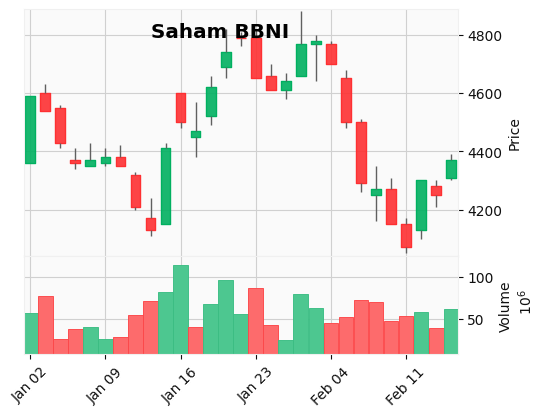

<function matplotlib.pyplot.show(close=None, block=None)>

In [4]:
dfVisual = df.loc["2025-01-01":].copy()

mpf.plot(dfVisual, type='candle', style='yahoo', title='Saham BBNI',
         ylabel='Price', ylabel_lower='Volume', figsize=(5,4),
         volume=True, tight_layout=True)

mpf.show


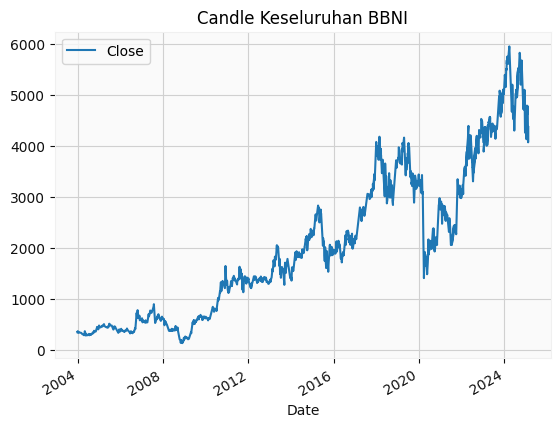

In [5]:
df.plot.line(y="Close", use_index=True)
plt.title("Candle Keseluruhan BBNI")
plt.show()

mengambil dataframe dari tanggal 1-1-2020 dan seterusnya

In [6]:
df = df.loc["2020-01-01":].copy()

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1240 entries, 2020-01-02 00:00:00+07:00 to 2025-02-14 00:00:00+07:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1240 non-null   float64
 1   High    1240 non-null   float64
 2   Low     1240 non-null   float64
 3   Close   1240 non-null   float64
 4   Volume  1240 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 58.1 KB


mengambil data harga penutupan dari DataFrame, mengubahnya menjadi array NumPy, dan kemudian membentuk kembali (reshape) array tersebut menjadi array 2D dengan satu kolom.

In [10]:
# Memuat data
prices = df['Close'].values.reshape(-1, 1)

In [13]:
prices

array([[3363.98657227],
       [3374.8034668 ],
       [3299.08691406],
       ...,
       [4300.        ],
       [4250.        ],
       [4370.        ]])

## 3.Preprocessing data

In [15]:
# Menormalkan data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler.fit_transform(prices)

# Membagi data menjadi data latih dan data uji
train_size = int(len(scaled_prices) * 0.8)
train_data = scaled_prices[:train_size]
test_data = scaled_prices[train_size:]

mengatur data ke dalam format yang sesuai untuk model machine learning dengan menggunakan konsep lookback untuk membuat fitur dari data historis

In [16]:
# Membuat dataset latih dan uji
def create_dataset(data, lookback):
    X, Y = [], []
    for i in range(len(data) - lookback):
      X.append(data[i:i+lookback])
      Y.append(data[i+lookback])
    return np.array(X), np.array(Y)

lookback = 10
X_train, Y_train = create_dataset(train_data, lookback)
test_X, test_Y = create_dataset(test_data, lookback)


## 4. Build model

In [17]:
# Membangun model RNN
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(units=32, input_shape=(lookback, 1)),
    tf.keras.layers.Dense(units=1)
])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 32)                  │           1,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,121 (4.38 KB)

 Trainable params: 1,121 (4.38 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [19]:
# train model
model.fit(X_train, Y_train, epochs=50, batch_size=32)

Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0166
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.1800e-04
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.1208e-04
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3709e-04
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.6132e-04
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1814e-04
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.6298e-04
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.6278e-04
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.9118e-04
Epoch 10/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.6366e-04
Epoch 11/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.5416e-04
Epoch 12/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.2510e-04
Epoch 13/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.1837e-04
Epoch 14/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.2877e-04
Epoch 15/50
31/31 ━━━━━━━━━━━━━━━

In [20]:
# Melakukan prediksi
train_preds = model.predict(X_train)
test_preds = model.predict(test_X)

# Menormalkan kembali data
train_preds = scaler.inverse_transform(train_preds)
Y_train = scaler.inverse_transform(Y_train)
test_preds = scaler.inverse_transform(test_preds)
test_Y = scaler.inverse_transform(test_Y)

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


## 5. Evaluasi

In [21]:
# Menghitung metrik evaluasi
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(test_Y, test_preds)
mae = mean_absolute_error(test_Y, test_preds)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)

Mean Squared Error (MSE): 12780.980663760622
Mean Absolute Error (MAE): 92.33803115972954


Nilai MSE 12780.9 menunjukkan bahwa rata-rata kuadrat kesalahan prediksi  adalah sekitar 12780.9 unit (kuadrat dari satuan harga saham)
Nilai MAE 92.33 berarti bahwa rata-rata kesalahan prediksi adalah sekitar 92.33 unit (satuan harga saham).

memvisualisasikan hasil forecasting harga saham BBNI. Memplot harga aktual, prediksi data latih, dan prediksi data uji dalam satu grafik.

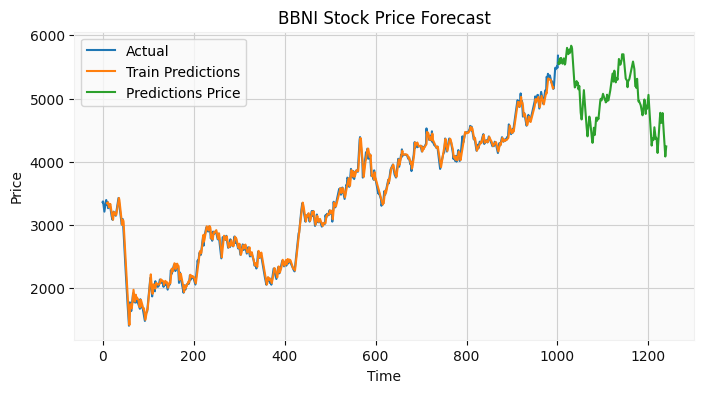

In [22]:
plt.figure(figsize=(8, 4))
plt.plot(prices[:train_size + lookback], label='Actual')
plt.plot(range(lookback, train_size), train_preds, label='Train Predictions')
plt.plot(range(train_size + lookback, len(prices)), test_preds, label='Predictions Price')
plt.xlabel("Time")
plt.ylabel("Price")
plt.title("BBNI Stock Price Forecast")
plt.legend()
plt.show()

In [23]:
# Mengambil periode yang sesuai untuk Test Predictions dan Actual
test_actual = prices[train_size + lookback:]

# Membuat DataFrame untuk perbandingan
comparison_df = pd.DataFrame({'Harga Actual': test_actual.flatten(),
                              'Harga Prediksi': test_preds.flatten()})
#menampilkan dataframe perbandingan
comparison_df


,Harga Actual,Harga Prediksi
0,5607.047363,5565.821777
1,5726.346191,5543.683105
2,5726.346191,5624.645508
3,5607.047363,5631.720215
4,5750.205566,5557.918945
...,...,...
233,4150.000000,4272.383789
234,4070.000000,4172.059570
235,4300.000000,4084.581787
236,4250.000000,4229.081543
